In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as opt
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#資料視覺化

In [ ]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df_confirmed = pd.read_csv(url)
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
df_deaths = pd.read_csv(url)
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
df_recovered = pd.read_csv(url)

各國確診數

In [ ]:
df_list = [df_confirmed,df_deaths,df_recovered]
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
case_color = ['orange','red','green','blue']
case_dict = {cases[i]:case_color[i] for i in range(len(cases))}

In [ ]:
## creating time series data

time_series_data = pd.DataFrame()
for i in range(len(cases)-1):
    df =  pd.DataFrame(df_list[i][df_list[i].columns[4:]].sum(),columns=[cases[i]])
    time_series_data = pd.concat([time_series_data,df],axis = 1)
time_series_data.index = pd.to_datetime(time_series_data.index,format='%m/%d/%y')
time_series_data['Active'] = time_series_data['Confirmed'] - time_series_data['Deaths'] - time_series_data['Recovered']
time_series_data= time_series_data.rename_axis('ObservationDate').reset_index()

In [ ]:
country_wise_data = pd.DataFrame()
for i in range(len(cases)-1):
    series =  df_list[i][df_list[i].columns[4:]].sum(axis = 1)
    df = pd.concat([df_list[i]['Country/Region'] ,series],axis = 1)
    df = df.groupby('Country/Region').sum().rename(columns = {0:cases[i]})
    country_wise_data = pd.concat([country_wise_data,df],axis = 1)
country_wise_data['Active'] = country_wise_data['Confirmed'] - country_wise_data['Deaths'] - country_wise_data['Recovered']
country_wise_data = country_wise_data.reset_index()

country_wise_data.head(10)

,Country/Region,Confirmed,Deaths,Recovered,Active
0,Afghanistan,49761190,2156442,18289880,29314868
1,Albania,57195633,995178,22652652,33547803
2,Algeria,70186115,2011178,25670233,42504704
3,Andorra,6050263,61681,3085649,2902933
4,Angola,17097772,425302,5895800,10776670
5,Antigua and Barbuda,763609,20808,191813,550988
6,Argentina,1655034735,36775187,711610324,906649224
7,Armenia,104594678,2074525,51634388,50885765
8,Australia,42291516,586412,8821094,32884010
9,Austria,287801673,4276665,131744371,151780637


In [ ]:
country_wise_data = country_wise_data.sort_values(by='Confirmed',ascending=False).reset_index(drop = True)
country_wise_data.head(10)

,Country/Region,Confirmed,Deaths,Recovered,Active
0,US,15624568214,280497511,496971828,14847098875
1,India,10687837787,143868142,4859387857,5684581788
2,Brazil,7347028355,203501695,3412350387,3731176273
3,Russia,2628326818,64487155,1128064202,1435775461
4,United Kingdom,2573597483,59985815,3447801,2510163867
5,France,2477590673,49140364,96506536,2331943773
6,Turkey,2232877827,21145478,919259007,1292473342
7,Spain,1743237598,38353081,71183831,1633700686
8,Italy,1717784713,55701293,759237934,902845486
9,Argentina,1655034735,36775187,711610324,906649224


In [ ]:
country_wise_data = country_wise_data.sort_values(by='Confirmed',ascending=False).reset_index(drop = True)
country_wise_data.head(10)

,Country/Region,Confirmed,Deaths,Recovered,Active
0,US,15624568214,280497511,496971828,14847098875
1,India,10687837787,143868142,4859387857,5684581788
2,Brazil,7347028355,203501695,3412350387,3731176273
3,Russia,2628326818,64487155,1128064202,1435775461
4,United Kingdom,2573597483,59985815,3447801,2510163867
5,France,2477590673,49140364,96506536,2331943773
6,Turkey,2232877827,21145478,919259007,1292473342
7,Spain,1743237598,38353081,71183831,1633700686
8,Italy,1717784713,55701293,759237934,902845486
9,Argentina,1655034735,36775187,711610324,906649224


In [ ]:
df_confirmed = country_wise_data.loc[:,['Country/Region','Confirmed']].sort_values(by = 'Confirmed',ascending = False).reset_index(drop = True).head(10)
df_deaths =    country_wise_data.loc[:,['Country/Region','Deaths']].sort_values(by = 'Deaths',ascending = False).reset_index(drop = True).head(10)
df_active =    country_wise_data.loc[:,['Country/Region','Active']].sort_values(by = 'Active',ascending = False).reset_index(drop = True).head(10)
df_recovered =    country_wise_data.loc[:,['Country/Region','Recovered']].sort_values(by = 'Recovered',ascending = False).reset_index(drop = True).head(10)

In [ ]:
fig = px.bar(df_confirmed, x='Confirmed', y='Country/Region',
             hover_data=['Confirmed'],
             labels={},orientation='h', height=600, width=800)
fig.update_layout(title_text='<b>Total number of Confirmed cases</b>',title_x=0.5)
fig.show()

US得covid之情況

In [ ]:
df_us = pd.DataFrame([['Confirmed',country_wise_data.iloc[0][1]],
                      ['Deaths', country_wise_data.iloc[0][2]],
                      ['Recovered', country_wise_data.iloc[0][3]],
                      ['Active', country_wise_data.iloc[0][4]]],
                     columns=['category', 'count'])

px.bar(df_us, x='count', y='category', title='US',orientation='h')

# 資料預處理

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/深度學習/深度學習期末/time_series_covid_19_confirmed_US.csv')
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6773,6793,6819,6835,6876,6879,6882,6889,6890,6897,6904,6907,6909,6910,6910,6914,6914,6918,6918,6920,6920,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049,7106,7113,7118,7118,7126,7135,7141,7142,7142
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20764,20787,20815,20833,20838,20847,20863,20875,20897,20921,20941,20966,20983,20993,20993,21035,21093,21107,21123,21131,21135,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489,21511,21535,21546,21554,21578,21593,21606,21620,21620
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2275,2284,2289,2292,2296,2296,2296,2297,2298,2299,2300,2302,2302,2302,2302,2307,2307,2307,2307,2308,2308,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326,2327,2328,2328,2328,2331,2331,2333,2334,2334
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2569,2569,2573,2578,2582,2584,2584,2588,2591,2593,2594,2596,2596,2597,2597,2604,2604,2604,2605,2607,2607,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656,2657,2656,2658,2659,2660,2662,2666,2664,2664
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6548,6556,6563,6570,6570,6571,6574,6581,6595,6607,6613,6616,6619,6621,6621,6635,6645,6651,6656,6660,6661,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816,6826,6829,6832,6832,6847,6856,6862,6864,6864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3707,3711,3715,3719,3719,3719,3724,3725,3729,3730,3732,3732,3732,3739,3741,3744,3753,3751,3751,3751,3755,3758,3760,3762,3765,3765,3765,3769,3772,3770,3775,3776,3776,3776,3780,3780,3781,3781,3784,3784
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2155,2154,2157,2158,2158,2158,2165,2173,2180,2181,2183,2183,2183,2195,2204,2209,2211,2217,2217,2217,2229,2232,2234,2237,2239,2239,2239,2244,2249,2250,2251,2246,2246,2246,2252,2261,2263,2264,2266,2266
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,898,898,898,898,898,898,898,901,903,903,903,903,903,906,906,911,911,911,911,911,912,913,914,918,918,918,918,917,917,920,921,921,921,92

累加確診人數

In [ ]:
time_series_data = pd.DataFrame()
df = pd.DataFrame(df[df.columns[11:]].sum(), columns=['confirmed'])
time_series_data = pd.concat([time_series_data,df], axis=1)
time_series_data.index = pd.to_datetime(time_series_data.index, format='%m/%d/%y')
time_series_data.reset_index(inplace=True)
time_series_data

,index,confirmed
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,5
...,...,...
489,2021-05-25,33166418
490,2021-05-26,33190470
491,2021-05-27,33217995
492,2021-05-28,33239963


In [ ]:
fig = px.scatter(time_series_data, x='index', y='confirmed', hover_data=['confirmed'], color='confirmed')
fig.show()

MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(time_series_data['confirmed'], axis=1))

time_series_data['confirmed'] = scaler.transform(np.expand_dims(time_series_data['confirmed'], axis=1))
time_series_data

,index,confirmed
0,2020-01-22,0.000000e+00
1,2020-01-23,0.000000e+00
2,2020-01-24,3.007344e-08
3,2020-01-25,3.007344e-08
4,2020-01-26,1.202937e-07
...,...,...
489,2021-05-25,9.974281e-01
490,2021-05-26,9.981514e-01
491,2021-05-27,9.989792e-01
492,2021-05-28,9.996398e-01


切割資料集

In [ ]:
split = round(0.8*len(time_series_data))
train_data = time_series_data['confirmed'][:split]
test_data = time_series_data['confirmed'][split:]
print(train_data.shape)
print(test_data.shape)

(395,)
(99,)


建立序列

In [ ]:
def create_sequences(data, previous):
  X, y = [], []
  for i in range(len(data)-previous-1):
      x = data[i:(i+previous)]
      X.append(x)
      y.append(data[i+previous])
  X = np.array(X)
  y = np.array(y)

  return X, y

In [ ]:
previous = 5 #利用前五天預測第六天的確診人數
X_train, y_train = create_sequences(train_data.to_numpy(), previous)
X_test, y_test = create_sequences(test_data.to_numpy(), previous)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_train = X_train.unsqueeze(2)
X_test = X_test.unsqueeze(2)
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

# 建構模型

## SimpleRNN

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_class):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)
    
  def forward(self, x):
    out, _ = self.rnn(x)
    out = out[:, -1, :]
    out = self.fc(out)
    return out

## LSTM

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_class):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)
    
  def forward(self, x):
    h0 = Variable(torch.zeros(num_layers, x.size(0), hidden_size))
    c0 = Variable(torch.zeros(num_layers, x.size(0), hidden_size))
    out, _ = self.lstm(x, (h0, c0))
    out = out[:, -1, :]
    out = self.fc(out)
    return out

## GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_class):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

## CNN+LSTM

In [ ]:
class ConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_class):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.conv = nn.Sequential(
            nn.Conv1d(5, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, kernel_size=1)
        )
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.LSTM2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        out = self.conv(x)
        out, _ = self.LSTM1(out)
        out, _ = self.LSTM2(out)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

## 模型架構

In [ ]:
input_size = 1
hidden_size = 64 #memory cell的大小
num_layers = 1
num_class = 1 #output layer的node數

In [ ]:
rnn = RNN(input_size, hidden_size, num_layers, num_class)
print(rnn)
lstm = LSTM(input_size, hidden_size, num_layers, num_class)
print(lstm)
gru = GRU(input_size, hidden_size, num_layers, num_class)
print(gru)
convlstm = ConvLSTM(input_size, hidden_size, 2, num_class)
print(convlstm)

RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
GRU(
  (gru): GRU(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
ConvLSTM(
  (conv): Sequential(
    (0): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (LSTM1): LSTM(1, 64, num_layers=2, batch_first=True)
  (LSTM2): LSTM(64, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


## 模型訓練

In [ ]:
def train_model(model, X_train, y_train, X_test=None, y_test=None):
  loss_fn = nn.MSELoss()
  optimizer = opt.Adam(model.parameters(), lr = 0.001)
  num_epoches = 200

  train_loss_hist = np.zeros(num_epoches)
  test_loss_hist = np.zeros(num_epoches)

  for epoch in range(num_epoches):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred, y_test)
      test_loss_hist[epoch] = test_loss.data

      if (epoch+1)%10 == 0:
        print('Epoch: %d, Train Loss: %.4f, Test Loss: %.4f' %  (epoch+1, loss.data, test_loss.data))
    else:
      if (epoch+1)%10 == 0:
        print('Epoch: %d, Loss: %.4f' %  (epoch+1, loss.data))
    train_loss_hist[epoch] = loss.data 
    
  return y_pred, train_loss_hist, test_loss_hist  

# 訓練結果

In [ ]:
def loss_plot(model, X_train, y_train, X_test, y_test):
  y_pred, train_loss_hist, test_loss_hist = train_model(model, X_train, y_train, X_test, y_test)
  plt.plot(train_loss_hist, label='Train Loss')
  plt.plot(test_loss_hist, label='Test Loss')
  plt.legend()

In [ ]:
def result_plot(model, train_data, X_test, y_test):
  with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = y_test_pred.flatten()

  train_data = scaler.inverse_transform(train_data.values.reshape(-1,1))
  y_test = scaler.inverse_transform(y_test.reshape(-1,1))
  y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1,1))

  plt.plot(time_series_data['confirmed'].index[:len(train_data)],
          train_data,
          label = 'Historical Cumulative Cases')
  plt.plot(time_series_data['confirmed'].index[len(train_data):len(train_data)+len(y_test_pred)],
          y_test,
          label = 'Real Cumulative Cases')
  plt.plot(time_series_data['confirmed'].index[len(train_data):len(train_data)+len(y_test_pred)],
          y_test_pred,
          label = 'Predicted Cumulative Cases')
  plt.legend()

## SimpleRNN

Epoch: 10, Train Loss: 0.0377, Test Loss: 0.2793
Epoch: 20, Train Loss: 0.0092, Test Loss: 0.0378
Epoch: 30, Train Loss: 0.0044, Test Loss: 0.0251
Epoch: 40, Train Loss: 0.0003, Test Loss: 0.0065
Epoch: 50, Train Loss: 0.0003, Test Loss: 0.0030
Epoch: 60, Train Loss: 0.0002, Test Loss: 0.0003
Epoch: 70, Train Loss: 0.0000, Test Loss: 0.0011
Epoch: 80, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 90, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 100, Train Loss: 0.0000, Test Loss: 0.0004
Epoch: 110, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 120, Train Loss: 0.0000, Test Loss: 0.0003
Epoch: 130, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 140, Train Loss: 0.0000, Test Loss: 0.0003
Epoch: 150, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 160, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 170, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 180, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 190, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 200, Train Loss: 0.0000, Test Loss: 0.0002


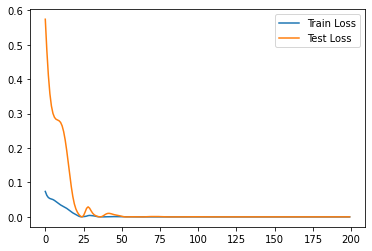

In [ ]:
loss_plot(rnn, X_train, y_train, X_test, y_test)

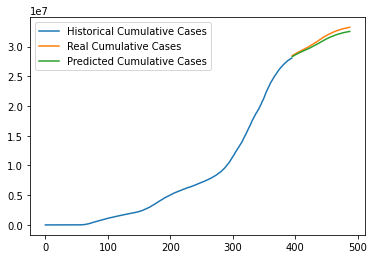

In [ ]:
result_plot(rnn, train_data, X_test, y_test)

## LSTM

Epoch: 10, Train Loss: 0.0558, Test Loss: 0.4597
Epoch: 20, Train Loss: 0.0495, Test Loss: 0.3443
Epoch: 30, Train Loss: 0.0392, Test Loss: 0.3066
Epoch: 40, Train Loss: 0.0251, Test Loss: 0.1633
Epoch: 50, Train Loss: 0.0060, Test Loss: 0.0180
Epoch: 60, Train Loss: 0.0023, Test Loss: 0.0430
Epoch: 70, Train Loss: 0.0003, Test Loss: 0.0037
Epoch: 80, Train Loss: 0.0006, Test Loss: 0.0001
Epoch: 90, Train Loss: 0.0002, Test Loss: 0.0032
Epoch: 100, Train Loss: 0.0002, Test Loss: 0.0035
Epoch: 110, Train Loss: 0.0001, Test Loss: 0.0007
Epoch: 120, Train Loss: 0.0001, Test Loss: 0.0009
Epoch: 130, Train Loss: 0.0001, Test Loss: 0.0009
Epoch: 140, Train Loss: 0.0000, Test Loss: 0.0004
Epoch: 150, Train Loss: 0.0000, Test Loss: 0.0003
Epoch: 160, Train Loss: 0.0000, Test Loss: 0.0002
Epoch: 170, Train Loss: 0.0000, Test Loss: 0.0001
Epoch: 180, Train Loss: 0.0000, Test Loss: 0.0001
Epoch: 190, Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 200, Train Loss: 0.0000, Test Loss: 0.0000


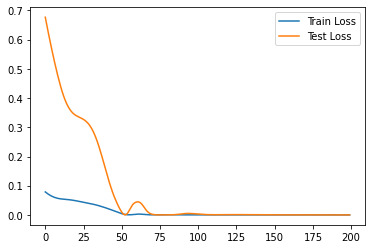

In [ ]:
loss_plot(lstm, X_train, y_train, X_test, y_test)

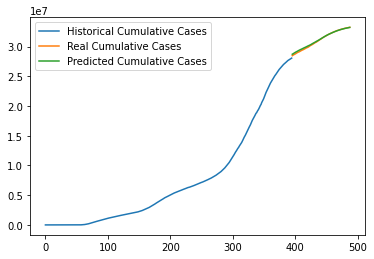

In [ ]:
result_plot(lstm, train_data, X_test, y_test)

## GRU

Epoch: 10, Train Loss: 0.0530, Test Loss: 0.4332
Epoch: 20, Train Loss: 0.0430, Test Loss: 0.2317
Epoch: 30, Train Loss: 0.0274, Test Loss: 0.2062
Epoch: 40, Train Loss: 0.0135, Test Loss: 0.0816
Epoch: 50, Train Loss: 0.0019, Test Loss: 0.0011
Epoch: 60, Train Loss: 0.0011, Test Loss: 0.0249
Epoch: 70, Train Loss: 0.0004, Test Loss: 0.0058
Epoch: 80, Train Loss: 0.0002, Test Loss: 0.0002
Epoch: 90, Train Loss: 0.0002, Test Loss: 0.0010
Epoch: 100, Train Loss: 0.0001, Test Loss: 0.0029
Epoch: 110, Train Loss: 0.0001, Test Loss: 0.0022
Epoch: 120, Train Loss: 0.0001, Test Loss: 0.0014
Epoch: 130, Train Loss: 0.0001, Test Loss: 0.0014
Epoch: 140, Train Loss: 0.0001, Test Loss: 0.0015
Epoch: 150, Train Loss: 0.0001, Test Loss: 0.0013
Epoch: 160, Train Loss: 0.0001, Test Loss: 0.0011
Epoch: 170, Train Loss: 0.0001, Test Loss: 0.0010
Epoch: 180, Train Loss: 0.0001, Test Loss: 0.0009
Epoch: 190, Train Loss: 0.0000, Test Loss: 0.0008
Epoch: 200, Train Loss: 0.0000, Test Loss: 0.0007


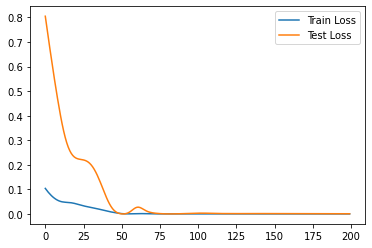

In [ ]:
loss_plot(gru, X_train, y_train, X_test, y_test)

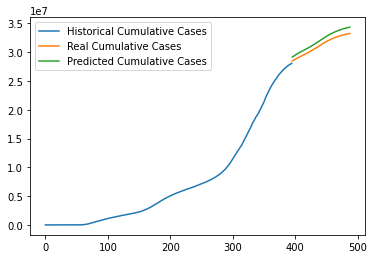

In [ ]:
result_plot(gru, train_data, X_test, y_test)

## CNN+LSTM

Epoch: 10, Train Loss: 0.0637, Test Loss: 0.4477
Epoch: 20, Train Loss: 0.0617, Test Loss: 0.5403
Epoch: 30, Train Loss: 0.0611, Test Loss: 0.4896
Epoch: 40, Train Loss: 0.0609, Test Loss: 0.5016
Epoch: 50, Train Loss: 0.0600, Test Loss: 0.4951
Epoch: 60, Train Loss: 0.0215, Test Loss: 0.1306
Epoch: 70, Train Loss: 0.0052, Test Loss: 0.0272
Epoch: 80, Train Loss: 0.0025, Test Loss: 0.0103
Epoch: 90, Train Loss: 0.0012, Test Loss: 0.0085
Epoch: 100, Train Loss: 0.0007, Test Loss: 0.0176
Epoch: 110, Train Loss: 0.0005, Test Loss: 0.0159
Epoch: 120, Train Loss: 0.0004, Test Loss: 0.0092
Epoch: 130, Train Loss: 0.0003, Test Loss: 0.0063
Epoch: 140, Train Loss: 0.0003, Test Loss: 0.0063
Epoch: 150, Train Loss: 0.0002, Test Loss: 0.0062
Epoch: 160, Train Loss: 0.0002, Test Loss: 0.0057
Epoch: 170, Train Loss: 0.0001, Test Loss: 0.0048
Epoch: 180, Train Loss: 0.0001, Test Loss: 0.0041
Epoch: 190, Train Loss: 0.0001, Test Loss: 0.0032
Epoch: 200, Train Loss: 0.0000, Test Loss: 0.0023


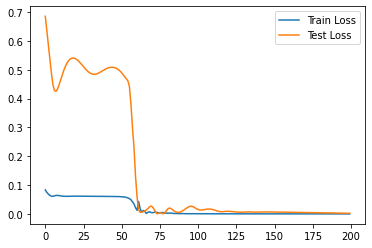

In [ ]:
loss_plot(convlstm, X_train, y_train, X_test, y_test)

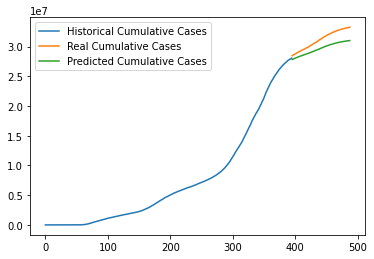

In [ ]:
result_plot(convlstm, train_data, X_test, y_test)

## 預測未來

In [ ]:
def predict(model, num_prediction):
  with torch.no_grad():
    T = 5
    predict_list = time_series_data['confirmed'][-T:]
    num_prediction = num_prediction
    for _ in range(num_prediction):
      x = predict_list[-T:]
      x = np.array(x)
      x = torch.tensor(x).float()
      x = x.reshape((1,T,1))
      pred = model(x)
      predict_list = np.append(predict_list, pred)
  predict_list = predict_list[T-1:]
  predict_list = scaler.inverse_transform(predict_list.reshape(-1,1)).astype(int)
  last_date = time_series_data['index'].values[-1]
  predict_dates = np.array(pd.date_range(last_date, periods=num_prediction+1))
  return predict_dates, predict_list

In [ ]:
real_comfirmed = scaler.inverse_transform(time_series_data['confirmed'].values.reshape(-1,1))

In [ ]:
rnn_predict_dates, rnn_predict_list = predict(rnn, 30)
lstm_predict_dates, lstm_predict_list = predict(lstm, 30)
gru_predict_dates, gru_predict_list = predict(gru, 30)
convlstm_predict_dates, convlstm_predict_list = predict(convlstm, 30)

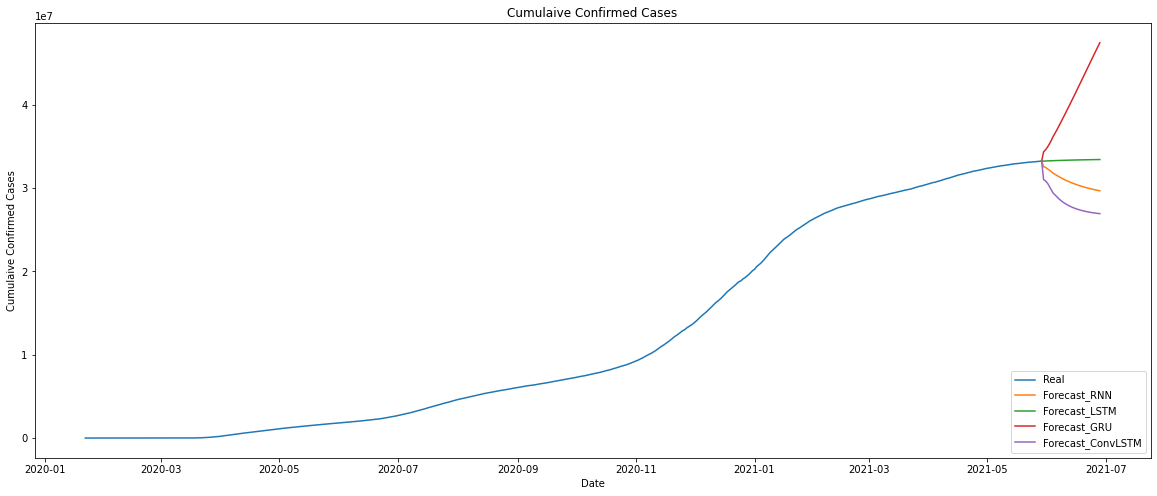

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(time_series_data['index'], real_comfirmed)
plt.plot(rnn_predict_dates, rnn_predict_list)
plt.plot(lstm_predict_dates, lstm_predict_list)
plt.plot(gru_predict_dates, gru_predict_list)
plt.plot(convlstm_predict_dates, convlstm_predict_list)
plt.title('Cumulaive Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Cumulaive Confirmed Cases')
plt.legend(['Real','Forecast_RNN','Forecast_LSTM','Forecast_GRU','Forecast_ConvLSTM'],loc = 'lower right')
plt.show()